## Imports
*Please see the markdown reports at the very end of the file.*


In [ ]:
#!pip install wandb

In [ ]:
import numpy as np
import pickle
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.nn import functional as F
from tqdm.auto import tqdm
from PIL import Image
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
#import wandb
#wandb.init(project="4211", sync_tensorboard=True)
%matplotlib inline

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Define DataSet


In [ ]:
class MyDataset(Dataset):

    def __init__(self, folders, transform=None):
        self.folders, self.labels = self.get_labels(folders)
        self.transform = transform

    def __len__(self):
        return len(self.folders)
    
    def __getitem__(self, idx):
        folder_id = self.folders[idx]
        
        try:
            with open(folder_id, 'rb') as f:
                color_img = pickle.load(f)
        except EOFError:
            print(folder_id)

        # img process
        #for i in range(color_img.shape[0]):
        #    if np.ptp(color_img[i, :, :]) != 0:
        #        color_img[i,:,:] = (color_img[i,:,:] - np.min(color_img[i,:,:])) / np.ptp(color_img[i,:,:])
        color_img = color_img.transpose((1,2,0))

        # img process
        c1 = color_img[:,:,0]
        c2 = color_img[:,:,1]
        c3 = color_img[:,:,2]
        c4 = color_img[:,:,3]
        
        c1 = np.expand_dims(c1, axis=2)
        c2 = np.expand_dims(c2, axis=2)
        c3 = np.expand_dims(c3, axis=2)
        c4 = np.expand_dims(c4, axis=2)

        color_img = np.concatenate((c1, c2, c3, c4), axis=2)
        #for i in range(color_img.shape[2]):
        #    if np.ptp(color_img[:,:,i]) == 0:
         #       continue
         #   color_img[:,:,i] = (color_img[:,:,i] - np.min(color_img[:,:,i])) / np.ptp(color_img[:,:,i])

        # img process, tranform
        if self.transform is not None:
            color_img = np.uint8(255*color_img)
            color_img = Image.fromarray(color_img)
            color_img = self.transform(color_img)

        return color_img, self.labels[idx]


    def get_labels(self, folders):

        files = []
        labels = []

        #conding=utf8  
        g = os.walk(folders)  

        for path, _, file_list in g:  
            for file_name in file_list:
                files.append(os.path.join(path, file_name))
                if 'nil_HS_H08' in file_name or 'light_HS_H08' in file_name:
                    labels.append(0)
                elif 'moderate_HS_H08' in file_name:
                    labels.append(1)
                else:
                    labels.append(2)
                
        return files, labels

### Transform raw data

In [ ]:
pre_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    #transforms.RandomCrop(200),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomAffine(30),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

### Load Data

In [ ]:
train_dataset = MyDataset("./drive/MyDrive/proj1_data/train",pre_transform)
val_dataset = MyDataset("./drive/MyDrive/proj1_data/validate",val_transform)

In [ ]:

print("train data length: %d  valid data length % d"%(len(train_dataset),len(val_dataset)))

train data length: 1754  valid data length  306


### Visualize Traning Data

This is class MOD
torch.Size([4, 224, 224])
tensor([[0.1725, 0.1725, 0.1725,  ..., 0.9725, 0.9725, 0.9725],
        [0.1725, 0.1725, 0.1725,  ..., 0.7765, 0.7765, 0.7765],
        [0.1725, 0.1725, 0.1725,  ..., 0.3608, 0.7765, 0.7765],
        ...,
        [0.0314, 0.8902, 0.8902,  ..., 0.3059, 0.3059, 0.4824],
        [0.0314, 0.0314, 0.0314,  ..., 0.9569, 0.9569, 0.3059],
        [0.0314, 0.0314, 0.0314,  ..., 0.9569, 0.9569, 0.3059]])


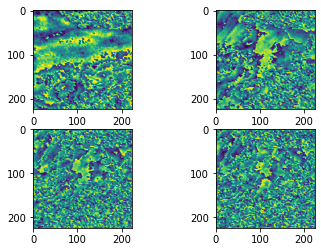

In [ ]:
img,label = train_dataset[0]
if (label == 0):
  print("This is class nil")
elif (label == 1):
  print("This is class MOD")
else:
  print("This is class SEV")
print(img.shape)
Band8 = img[0][:][:]
Band12 = img[1][:][:]
Band13 = img[2][:][:]
Band14 = img[3][:][:]
Band = [Band8,Band12,Band13,Band14]
print(Band8)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.imshow(Band[i-1])
plt.show()


In [ ]:
# #Calculate the number of samples in differnet class
# train_nil_count = 0   ##591
# train_MOD_count = 0   ##839
# train_SEV_count = 0   ##324
# valid_nil_count = 0   ##192
# valid_MOD_count = 0   ##81
# valid_SEV_count = 0   ##33

# for i in range (0,1754):
#     #print(i)
#     img, label = train_dataset[i]
#     if (label == 0):
#         train_nil_count += 1
#     elif (label == 1):
#         train_MOD_count += 1
#     else:
#         train_SEV_count += 1
# print("train set has %d nil, %d MOD, %d SEV" %(train_nil_count, train_MOD_count, train_SEV_count))

# for i in range (0,306):
#     #print(i)
#     img, label = val_dataset[i]
#     if (label == 0):
#         valid_nil_count += 1
#     elif (label == 1):
#         valid_MOD_count += 1
#     else:
#         valid_SEV_count += 1
# print("valid set has %d nil, %d MOD, %d SEV" %(valid_nil_count, valid_MOD_count, valid_SEV_count))

## Define Model & Loss 

### Resnet Model

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, pin_memory=False)

In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
fc_features = model.fc.in_features
model.fc = nn.Linear(fc_features, 3)
model.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
print(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### LDAM Loss

In [ ]:
def LDAMLoss(output, target, n_class_nil, n_class_MOD, n_class_SEV, C):
      loss = 0
      n_class = [n_class_nil, n_class_MOD, n_class_SEV]
      #output_class = output.argmax(dim=1, keepdim=False) #Shape [64], the predict class
      niter = output.shape[0] # 64 for a batch
      for i in range(niter):

          Z_y = output[i][target[i]]
          delta_y = C / (n_class[target[i]] ** (0.25) )
          nominator = torch.exp(Z_y - delta_y)
          if (target[i] == 0):
              dinominator = nominator + torch.exp(output[i][1]) + torch.exp(output[i][2])
          elif (target[i] == 1):
              dinominator = nominator + torch.exp(output[i][0]) + torch.exp(output[i][2])
          else:
              dinominator = nominator + torch.exp(output[i][0]) + torch.exp(output[i][1])
          loss += (-torch.log(nominator/dinominator))
      return loss



## Evaluation Function

In [ ]:
def compute_acc(outputs, targets):
    preds = outputs.argmax(dim=1, keepdim=True)
    return preds.eq(targets.view_as(preds)).sum().item() / targets.shape[0]

In [ ]:
def performance_eval(outputs, targets):
    preds = outputs.argmax(dim=1, keepdim=False)
    targets = targets.view_as(preds)
    performance_dict = {"NIL":0.0,"MOD":0.0, "SEV":0.0 }
    for i in range(3):
        TP = targets[preds.eq(i)].eq(i).sum().item()
        FP = (~targets[preds.eq(i)].eq(i)).sum().item()
        FN = (~preds[targets.eq(i)].eq(i)).sum().item()
        Precision =  torch.true_divide(TP,(TP + FP))
        Recall = torch.true_divide(TP,(TP + FN))
        F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
        performance_dict[list(performance_dict.keys())[i]] = torch.tensor([Precision,Recall,F1])
    return performance_dict

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        self.TP = torch.tensor([0,0,0])
        self.FP = torch.tensor([0,0,0])
        self.FN = torch.tensor([0,0,0])
        
    def update(self, val, outputs, targets, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt
        preds = outputs.argmax(dim=1, keepdim=True)
        preds = preds.view(-1)
        targets = targets.view(-1)
        for i in range(3):
            self.TP[i] += targets[preds.eq(i)].eq(i).sum().item()
            self.FP[i] += (~targets[preds.eq(i)].eq(i)).sum().item()
            self.FN[i] += (~preds[targets.eq(i)].eq(i)).sum().item()

In [ ]:
model = model.cuda()
#optimizer = torch.optim.SGD(model.parameters(),lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
def train_one_epoch():
    accs = AverageMeter()

    for X, y in tqdm(train_loader, leave=False):
        inputs = X.cuda()
        targets = y.cuda()
        #inputs = X
        #targets = y
        optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        #loss = criterion(outputs, targets)
        loss = LDAMLoss(outputs,targets,591,839,324,C = 1.0)
        
        loss.backward()
        optimizer.step()
        accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
        
    return accs ,loss
def validate_one_epoch():
    accs = AverageMeter()

    for X, y in tqdm(val_loader, leave=False):
        inputs = X.cuda()
        targets = y.cuda()
        #inputs = X
        #targets = y
        #optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        #loss = criterion(outputs, targets)
        loss = LDAMLoss(outputs,targets,192,81,33,C = 1.0)

        #loss.backward()
        #optimizer.step()
        accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
    return accs , loss

In [ ]:
best_epoch = -1
best_acc = 0.0
history_acc = []
history_acc_2 = []
best_model_state = model.state_dict()
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
train_loss = 0
valid_loss = 0
for epoch in tqdm(range(20)):
    for phase in range (0,2):
      if phase == 0:
        model.train()
        accs ,train_loss= train_one_epoch()
        print("epoch {} train acc: {:.4f} ".format(epoch, accs.avg))
        class_names = ["NIL","MOD","SEV"]
        for i in range(3):
            Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
            Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
            F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
            #wandb.log({"train_acc":accs.avg,"train_loss": train_loss, "train_precision": Precision,"train_recall": Recall,"train_f1":F1}, step = epoch)
            print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))
        history_acc.append(accs)
        scheduler.step()

      elif phase == 1:
          model.eval()
          accs ,valid_loss = validate_one_epoch()
          print("epoch {} valid acc: {:.4f} ".format(epoch, accs.avg))
          class_names = ["NIL","MOD","SEV"]
          for i in range(3):
            Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
            Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
            F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
            #wandb.log({"valid_acc":accs.avg,"valid_loss": valid_loss, "valid_precision": Precision,"valid_recall": Recall,"valid_f1":F1}, step = epoch)

            print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))
            #history_acc.append(accs)  
          if accs.avg > best_acc:
            best_acc = accs.avg
            best_epoch = epoch
            best_model_state = model.state_dict()                  
          history_acc_2.append(accs)

print(f'[Info] best val acc: {best_acc:.2%} at {best_epoch+1}th epoch')



epoch 0 train acc: 0.9966 
class NIL Precision 0.998 Recall0.995 F1 0.997
class MOD Precision 0.996 Recall0.998 F1 0.997
class SEV Precision 0.994 Recall0.997 F1 0.995


epoch 0 valid acc: 0.7614 
class NIL Precision 0.985 Recall0.703 F1 0.821
class MOD Precision 0.547 Recall0.926 F1 0.688
class SEV Precision 0.719 Recall0.697 F1 0.708


epoch 1 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall1.000 F1 0.997


epoch 1 valid acc: 0.7810 
class NIL Precision 0.979 Recall0.740 F1 0.843
class MOD Precision 0.578 Recall0.914 F1 0.708
class SEV Precision 0.697 Recall0.697 F1 0.697


epoch 2 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.998 F1 0.998
class SEV Precision 0.997 Recall0.997 F1 0.997


epoch 2 valid acc: 0.7582 
class NIL Precision 0.986 Recall0.708 F1 0.824
class MOD Precision 0.540 Recall0.926 F1 0.682
class SEV Precision 0.724 Recall0.636 F1 0.677


epoch 3 train acc: 0.9977 
class NIL Precision 0.997 Recall1.000 F1 0.998
class MOD Precision 0.999 Recall0.996 F1 0.998
class SEV Precision 0.997 Recall0.997 F1 0.997


epoch 3 valid acc: 0.7549 
class NIL Precision 0.993 Recall0.703 F1 0.823
class MOD Precision 0.536 Recall0.926 F1 0.679
class SEV Precision 0.700 Recall0.636 F1 0.667


epoch 4 train acc: 0.9960 
class NIL Precision 0.997 Recall1.000 F1 0.998
class MOD Precision 0.999 Recall0.993 F1 0.996
class SEV Precision 0.988 Recall0.997 F1 0.992


epoch 4 valid acc: 0.7549 
class NIL Precision 0.993 Recall0.698 F1 0.820
class MOD Precision 0.536 Recall0.926 F1 0.679
class SEV Precision 0.710 Recall0.667 F1 0.688


epoch 5 train acc: 0.9977 
class NIL Precision 0.998 Recall0.998 F1 0.998
class MOD Precision 0.998 Recall0.998 F1 0.998
class SEV Precision 0.997 Recall0.997 F1 0.997


epoch 5 valid acc: 0.7516 
class NIL Precision 0.993 Recall0.698 F1 0.820
class MOD Precision 0.532 Recall0.926 F1 0.676
class SEV Precision 0.700 Recall0.636 F1 0.667


epoch 6 train acc: 0.9966 
class NIL Precision 0.997 Recall0.998 F1 0.997
class MOD Precision 0.999 Recall0.995 F1 0.997
class SEV Precision 0.991 Recall0.997 F1 0.994


epoch 6 valid acc: 0.7582 
class NIL Precision 0.986 Recall0.708 F1 0.824
class MOD Precision 0.540 Recall0.926 F1 0.682
class SEV Precision 0.724 Recall0.636 F1 0.677


epoch 7 train acc: 0.9949 
class NIL Precision 0.993 Recall0.998 F1 0.996
class MOD Precision 0.996 Recall0.993 F1 0.995
class SEV Precision 0.994 Recall0.994 F1 0.994


epoch 7 valid acc: 0.7712 
class NIL Precision 0.986 Recall0.719 F1 0.831
class MOD Precision 0.560 Recall0.926 F1 0.698
class SEV Precision 0.719 Recall0.697 F1 0.708


epoch 8 train acc: 0.9989 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.999 F1 0.999
class SEV Precision 1.000 Recall0.997 F1 0.998


epoch 8 valid acc: 0.7549 
class NIL Precision 0.985 Recall0.703 F1 0.821
class MOD Precision 0.536 Recall0.926 F1 0.679
class SEV Precision 0.724 Recall0.636 F1 0.677


epoch 9 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall1.000 F1 0.997


epoch 9 valid acc: 0.7680 
class NIL Precision 0.986 Recall0.714 F1 0.828
class MOD Precision 0.564 Recall0.926 F1 0.701
class SEV Precision 0.676 Recall0.697 F1 0.687


epoch 10 train acc: 0.9977 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall0.997 F1 0.995


epoch 10 valid acc: 0.7582 
class NIL Precision 0.986 Recall0.708 F1 0.824
class MOD Precision 0.543 Recall0.926 F1 0.685
class SEV Precision 0.700 Recall0.636 F1 0.667


epoch 11 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.998 F1 0.998
class SEV Precision 0.997 Recall0.997 F1 0.997


epoch 11 valid acc: 0.7549 
class NIL Precision 0.993 Recall0.703 F1 0.823
class MOD Precision 0.532 Recall0.926 F1 0.676
class SEV Precision 0.724 Recall0.636 F1 0.677


epoch 12 train acc: 0.9960 
class NIL Precision 0.990 Recall1.000 F1 0.995
class MOD Precision 0.999 Recall0.994 F1 0.996
class SEV Precision 1.000 Recall0.994 F1 0.997


epoch 12 valid acc: 0.7647 
class NIL Precision 0.986 Recall0.708 F1 0.824
class MOD Precision 0.551 Recall0.926 F1 0.691
class SEV Precision 0.719 Recall0.697 F1 0.708


epoch 13 train acc: 0.9977 
class NIL Precision 0.998 Recall0.998 F1 0.998
class MOD Precision 0.999 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall1.000 F1 0.997


epoch 13 valid acc: 0.7745 
class NIL Precision 0.986 Recall0.724 F1 0.835
class MOD Precision 0.564 Recall0.926 F1 0.701
class SEV Precision 0.719 Recall0.697 F1 0.708


epoch 14 train acc: 0.9949 
class NIL Precision 0.990 Recall0.998 F1 0.994
class MOD Precision 0.999 Recall0.993 F1 0.996
class SEV Precision 0.994 Recall0.994 F1 0.994


epoch 14 valid acc: 0.7712 
class NIL Precision 0.986 Recall0.729 F1 0.838
class MOD Precision 0.560 Recall0.926 F1 0.698
class SEV Precision 0.700 Recall0.636 F1 0.667


epoch 15 train acc: 0.9977 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.998 Recall0.998 F1 0.998
class SEV Precision 0.997 Recall0.994 F1 0.995


epoch 15 valid acc: 0.7582 
class NIL Precision 0.993 Recall0.708 F1 0.827
class MOD Precision 0.540 Recall0.926 F1 0.682
class SEV Precision 0.700 Recall0.636 F1 0.667


epoch 16 train acc: 0.9989 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.998 F1 0.999
class SEV Precision 0.997 Recall1.000 F1 0.998


epoch 16 valid acc: 0.7582 
class NIL Precision 0.985 Recall0.703 F1 0.821
class MOD Precision 0.543 Recall0.926 F1 0.685
class SEV Precision 0.710 Recall0.667 F1 0.688


epoch 17 train acc: 0.9977 
class NIL Precision 0.998 Recall0.998 F1 0.998
class MOD Precision 0.998 Recall0.998 F1 0.998
class SEV Precision 0.997 Recall0.997 F1 0.997


epoch 17 valid acc: 0.7516 
class NIL Precision 0.978 Recall0.698 F1 0.815
class MOD Precision 0.532 Recall0.926 F1 0.676
class SEV Precision 0.750 Recall0.636 F1 0.689


epoch 18 train acc: 0.9971 
class NIL Precision 0.995 Recall0.998 F1 0.997
class MOD Precision 0.999 Recall0.995 F1 0.997
class SEV Precision 0.997 Recall1.000 F1 0.998


epoch 18 valid acc: 0.7712 
class NIL Precision 0.986 Recall0.719 F1 0.831
class MOD Precision 0.556 Recall0.926 F1 0.694
class SEV Precision 0.742 Recall0.697 F1 0.719


epoch 19 train acc: 0.9983 
class NIL Precision 0.997 Recall1.000 F1 0.998
class MOD Precision 1.000 Recall0.996 F1 0.998
class SEV Precision 0.997 Recall1.000 F1 0.998


epoch 19 valid acc: 0.7647 
class NIL Precision 0.986 Recall0.708 F1 0.824
class MOD Precision 0.551 Recall0.926 F1 0.691
class SEV Precision 0.719 Recall0.697 F1 0.708

[Info] best val acc: 78.10% at 2th epoch


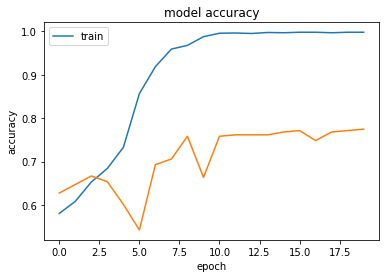

In [ ]:
accuracy = []
accuracy_2 = []

for accs in history_acc:
    accuracy.append(accs.avg)
for accs in history_acc_2:
    accuracy_2.append(accs.avg)
plt.plot(range(20),accuracy)
plt.plot(range(20),accuracy_2)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
model.eval()
for X, y in tqdm(val_loader, leave=False):
    inputs = X.cuda()
    outputs = model(inputs)
    print(outputs.shape)
    print(y.shape)
    print("y actual:",y)
    print(outputs)
    #print(outputs.argmax(dim=1, keepdim=True))
    acc = compute_acc(outputs.cpu(), y)
    print(f'Test Acc: {acc}')

torch.Size([64, 3])
torch.Size([64])
y actual: tensor([0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1])
tensor([[  0.7725,   2.1628,  -3.1691],
        [ -4.6347,  -0.4373,   4.4860],
        [ 11.5304,  -8.2634,  -4.8467],
        [ -3.0975,  -3.4022,   5.2859],
        [ 10.8117,  -5.7475,  -8.2332],
        [ -0.1563,   4.3385,  -4.1106],
        [  6.5803,  -2.2761,  -5.5671],
        [  1.9789,   1.0133,  -3.1913],
        [  6.5071,  -2.6810,  -5.3958],
        [  3.7537,  -1.5953,  -2.6043],
        [ -2.5932,   4.5876,  -1.6915],
        [  0.2297,   0.2843,  -1.0973],
        [  2.8386,   0.6125,  -3.6496],
        [ -1.2584,   5.7425,  -4.1336],
        [  6.3086,  -0.8388,  -5.6248],
        [ -1.0284,   3.4339,  -2.4005],
        [ -1.8595,   6.3331,  -4.0913],
        [  3.7537,  -1.5953,  -2.6043],
        [  4.472

In [ ]:
print(outputs.shape[0])
output_class = outputs.argmax(dim=1, keepdim=False)
print(output_class)

50
tensor([0, 1, 1, 2, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        1, 2, 1, 0, 0, 0, 1, 1, 0, 1, 2, 1, 1, 2, 1, 0, 0, 2, 1, 1, 0, 1, 1, 1,
        0, 1], device='cuda:0')


In [ ]:
print(y.shape)

torch.Size([50])
